### Importing required libraries

In [30]:
import re
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    
def plot_roc(model, X_test, y_test):
    proba = model.predict_proba(X_test)
    fpr,tpr, threshold = roc_curve(y_test,proba)
    auc_val = auc(fpr,tpr)

    plt.figure(figsize=(14,8))
    plt.title('Reciever Operating Charactaristics')
    plt.plot(fpr,tpr,'b',label = 'AUC = %0.2f' % auc_val)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    
#This is a function that reads a pre-trained embeddings file and returns a matrix embeddings for the dataset we are working with.
#Inputs are the filepath, the size of the embeddings (should match the pre-trained ones) and the word_indices as created by a tokenizer on our data
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

### Data cleaning functions

In [2]:
### Remove Punctuations and change words to lower case
def remove_punctuations(text):    
    words=[word.lower() for word in text.split()] 
    words=[w for word in words for w in re.sub(r'[^\w\s]','',word).split()]    
    return words

### Remove StopWords
stop = set(stopwords.words('english'))
def remove_stopwords(text):
    modified_word_list=[word for word in text if word not in stop]
    return modified_word_list

### Stemming of Words
from nltk.stem.porter import PorterStemmer
st=PorterStemmer()
def Stemming(text):
    stemmed_words=[st.stem(word) for word in text] 
    return stemmed_words

### Recreating the sentence
def Recreate(text):
    word=" ".join(text)
    return word

def Cleaning(text):
    text_punctuation_removed=remove_punctuations(text)
    text_stopword_removed=remove_stopwords(text_punctuation_removed)
    # text_stemmed=Stemming(text_stopword_removed)
    final_text=Recreate(text_stopword_removed)
    return final_text

## Importing the data

Importing the json file using pandas, article_link if no use so it gets dropped.

In [3]:
dataset = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True).drop(['article_link'], axis=1)
dataset.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


## Cleaning data and preprocessing

In [52]:
#dataset['clean_headline'] = dataset['headline'].apply(Cleaning)
dataset['clean_headline'] = dataset['headline'].apply(remove_punctuations)
dataset['clean_headline'] = dataset['clean_headline'].apply(Recreate)
dataset.head()

,headline,is_sarcastic,clean_headline
0,former versace store clerk sues over secret 'b...,0,former versace store clerk sues over secret bl...
1,the 'roseanne' revival catches up to our thorn...,0,the roseanne revival catches up to our thorny ...
2,mom starting to fear son's web series closest ...,1,mom starting to fear sons web series closest t...
3,"boehner just wants wife to listen, not come up...",1,boehner just wants wife to listen not come up ...
4,j.k. rowling wishes snape happy birthday in th...,0,jk rowling wishes snape happy birthday in the ...


In [53]:
sentences = dataset['clean_headline'].values  # text input (X)
y = dataset['is_sarcastic'].values             # labels

In [56]:
#split to train/test
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

#Build simple counts
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

### PCA for visualization

In [57]:
pca = PCA(n_components=2)
pca.fit(X_train)

X_embedded = pca.transform(X_train)

plt.figure()
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train, s=30, cmap='Set1')

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

### Defining a baseline model

In [58]:
from sklearn.linear_model import LogisticRegression

#Try a simple classifier
classifier = LogisticRegression(solver='lbfgs')
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
y_pred = classifier.predict(X_test)
print("Accuracy:", score)
print("Precision: %1.3f" % precision_score(y_test, y_pred))
print("Recall: %1.3f" % recall_score(y_test, y_pred))
print("F1: %1.3f\n" % f1_score(y_test, y_pred))
plot_roc(classifier, X_test, y_test)

Accuracy: 0.8328840970350404
Precision: 0.811
Recall: 0.805
F1: 0.808



C:\Users\nicol\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


ValueError: bad input shape (6678, 2)

### Word Embeddings

In [59]:
maxlen = 40

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences with zeros
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### Loading Glove pre-trained embeddings

In [62]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('glove.6B.50d.txt', tokenizer.word_index, embedding_dim)

### CNN

In [63]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen,trainable=True))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 40, 50)            1233500   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 36, 128)           32128     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
__________

Train on 20031 samples, validate on 6678 samples
Epoch 1/5
20031/20031 [==============================] - 28s 1ms/step - loss: 0.5406 - acc: 0.7178 - val_loss: 0.3909 - val_acc: 0.8291
Epoch 2/5
20031/20031 [==============================] - 26s 1ms/step - loss: 0.3166 - acc: 0.8750 - val_loss: 0.3423 - val_acc: 0.8528
Epoch 3/5
20031/20031 [==============================] - 26s 1ms/step - loss: 0.1844 - acc: 0.9338 - val_loss: 0.4089 - val_acc: 0.8544
Epoch 4/5
20031/20031 [==============================] - 27s 1ms/step - loss: 0.0957 - acc: 0.9669 - val_loss: 0.5021 - val_acc: 0.8534
Epoch 5/5
20031/20031 [==============================] - 28s 1ms/step - loss: 0.0484 - acc: 0.9850 - val_loss: 0.5828 - val_acc: 0.8497
Training Accuracy: 0.993
Testing Accuracy:  0.850
Precision: 0.806
Recall: 0.864
F1: 0.834



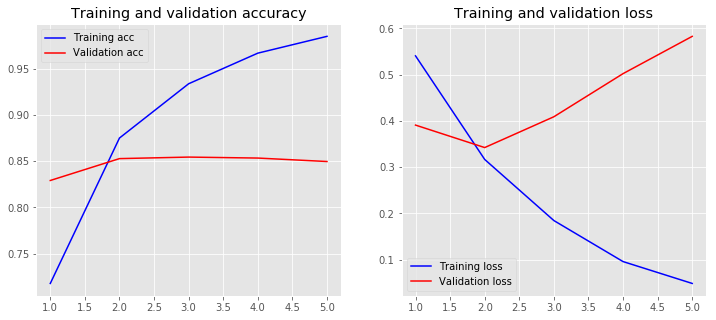

In [64]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: %1.3f" % accuracy)
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  %1.3f" % accuracy)
y_pred = model.predict(X_test)
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]

print("Precision: %1.3f" % precision_score(y_test, y_pred))
print("Recall: %1.3f" % recall_score(y_test, y_pred))
print("F1: %1.3f\n" % f1_score(y_test, y_pred))
plot_history(history)

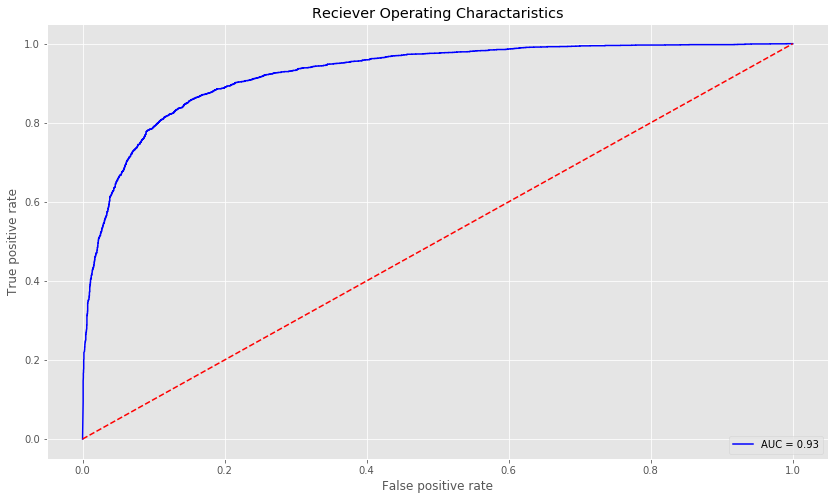

In [65]:
plot_roc(model, X_test, y_test)

### LSTM

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 40, 6)             148020    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 40, 32)            2944      
_________________________________________________________________
bidirectional_8 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 167,669
Trainable params: 167,669
Non-trainable params: 0
_________________________________________________________________
None
Train on 20031 samples, validate on 6678 samples
Epoch 1/10
20031/20031 [==============================] - 180s 9ms/step - loss: 0.4836 - acc: 0.7512 - val_loss: 0.3608 - val_acc: 0.8411
Epoch 2/10
20031/20031 [==============================] - 139s 7ms/step - lo

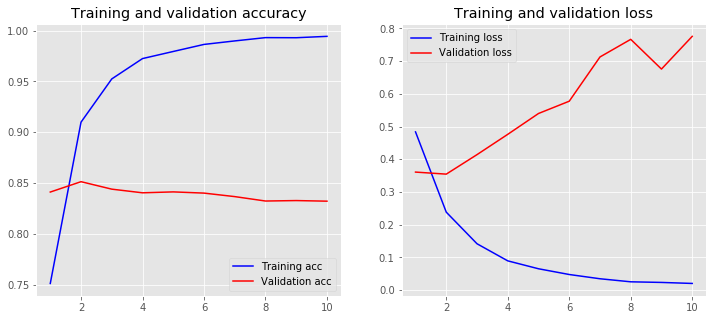

In [67]:
embedding_dim = 6
# create the model
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
# model.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model.add(layers.Bidirectional(layers.LSTM(16, return_sequences=True, recurrent_dropout=0.1, dropout=0.1)))
model.add(layers.Bidirectional(layers.LSTM(32, recurrent_dropout=0.1, dropout=0.1)))
model.add(layers.Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
y_pred = model.predict(X_test)
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]

print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Precision: %1.3f" % precision_score(y_test, y_pred))
print("Recall: %1.3f" % recall_score(y_test, y_pred))
print("F1: %1.3f\n" % f1_score(y_test, y_pred))
plot_history(history)

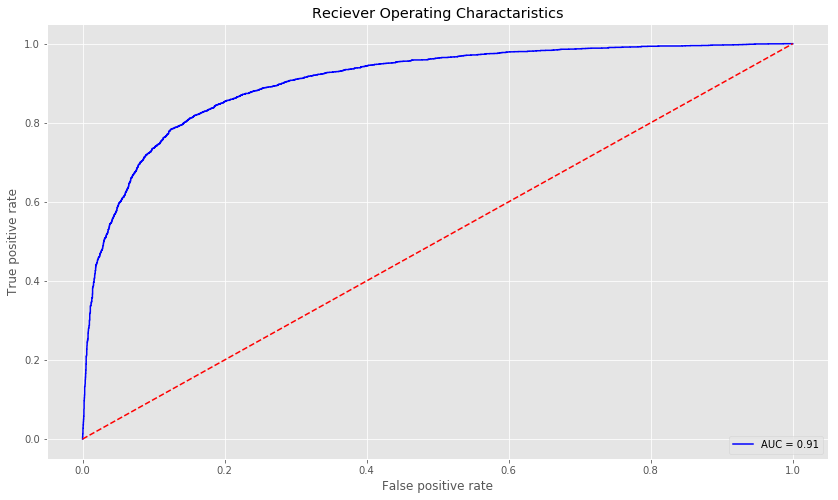

In [68]:
plot_roc(model, X_test, y_test)